In [124]:

%matplotlib inline

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import os
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import Projection
from scipy import ndimage as nd
from astropy.stats import histogram as astro_hist
from tqdm import tqdm
from corner import hist2d
from scipy import ndimage as nd

from pathlib import Path

osjoin = os.path.join

repo_path = os.path.expanduser("~/ownCloud/project_code/ThickHIFitting/")

figures_path_png = osjoin(repo_path, "figures/png")
figures_path_pdf = osjoin(repo_path, "figures/pdf")


def save_figure(fig, plot_name, **kwargs):
    fig.savefig(f"{figures_path_pdf}/{plot_name}.pdf", **kwargs)
    fig.savefig(f"{figures_path_png}/{plot_name}.png", **kwargs)


paths_script = os.path.join(repo_path, "paths.py")
exec(compile(open(paths_script, "rb").read(), paths_script, 'exec'))

plotstyle_script = os.path.join(repo_path, "plotting_styles.py")
exec(compile(open(plotstyle_script, "rb").read(), plotstyle_script, 'exec'))

model_script = os.path.join(repo_path, "gaussian_model.py")
exec(compile(open(model_script, "rb").read(), model_script, 'exec'))

thickHI_model_script = os.path.join(repo_path, "thickHI_model.py")
exec(compile(open(thickHI_model_script, "rb").read(),
             thickHI_model_script, 'exec'))


In [125]:
save_figures = True

In [126]:
# Load in the moment 0 maps from the data and the dark HI intensity maps

m31_mom0 = Projection.from_hdu(fits.open(fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Moment0'])).to(u.K * u.km / u.s)

print(fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Moment0'])

m33_mom0_name = "M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.moment0_Kkms.fits"
m33_mom0 = Projection.from_hdu(fits.open(fourteenB_HI_data_wGBT_path(m33_mom0_name))).to(u.K * u.km / u.s)

m31_darkhi_hdu_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_simplethick_HI_fits_5kms_centlimit_darkHI.fits")
m31_darkhi = Projection.from_hdu(fits.open(m31_darkhi_hdu_name)[0])
m31_residhi = Projection.from_hdu(fits.open(m31_darkhi_hdu_name)[3])

print(len(fits.open(m31_darkhi_hdu_name)))

m33_darkhi_hdu_name = fourteenB_HI_data_wGBT_path("individ_simplethick_HI_fits_5kms_centlimit_darkHI.fits")
m33_darkhi = Projection.from_hdu(fits.open(m33_darkhi_hdu_name)[0])
m33_residhi = Projection.from_hdu(fits.open(m33_darkhi_hdu_name)[3])
  
print(m31_mom0.beam)
print(m33_mom0.beam)
    
# Make "opaque-corrected" values.

# m31_opcorr_mom0 = m31_darkhi + (m31_mom0 - m31_residhi)
# m33_opcorr_mom0 = m33_darkhi + (m33_mom0 - m33_residhi)
# m31_opcorr_mom0 = m31_darkhi + m31_residhi
# m33_opcorr_mom0 = m33_darkhi + m33_residhi
m31_opcorr_mom0 = m31_darkhi + m31_mom0
m33_opcorr_mom0 = m33_darkhi + m33_mom0

/mnt/bigdata/ekoch/M31/VLA/15A-175/HI/full_imaging_BCD_taper_0_42kms_wEBHIS/M31_15A_B_C_14A_HI_contsub_width_0_4kms.image.pbcor.EBHIS_feathered_K.mom0.fits
6
Beam: BMAJ=17.887733459472656 arcsec BMIN=15.57705307006836 arcsec BPA=75.21550158527786 deg
Beam: BMAJ=18.98463225446057 arcsec BMIN=17.047559616101886 arcsec BPA=-81.81218585468574 deg


In [127]:
m31_opcorr_mom0.beam

Beam: BMAJ=17.887733459472656 arcsec BMIN=15.57705307006836 arcsec BPA=75.21550158527786 deg

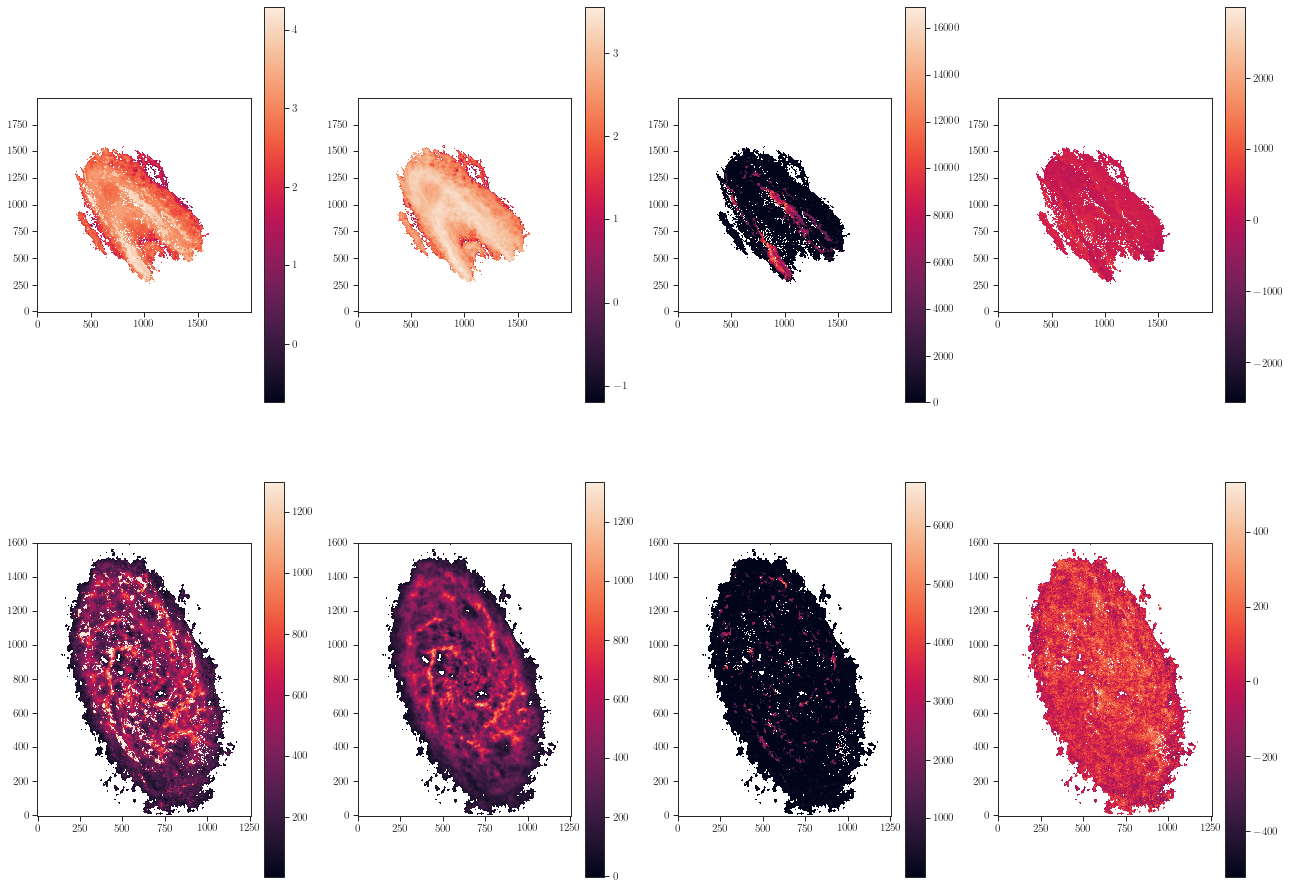

In [128]:
fig = plt.figure(figsize=(22, 16))

plt.subplot(241)
plt.imshow(np.log10(m31_opcorr_mom0.value), origin='lower')
plt.colorbar()
plt.subplot(242)
plt.imshow(np.log10(m31_mom0.value), origin='lower')
plt.colorbar()
plt.subplot(243)
plt.imshow(m31_darkhi.value, origin='lower')
plt.colorbar()
plt.subplot(244)
plt.imshow(m31_residhi.value, origin='lower')
plt.colorbar()

plt.subplot(245)
plt.imshow(m33_opcorr_mom0.value, origin='lower', vmax=1300)
plt.colorbar()
plt.subplot(246)
plt.imshow(m33_mom0.value, origin='lower')
plt.colorbar()
plt.subplot(247)
plt.imshow(m33_darkhi.value, origin='lower')
plt.colorbar()
plt.subplot(248)
plt.imshow(m33_residhi.value, origin='lower',) # vmax=1300, vmin=0)
plt.colorbar()


In [129]:
# y, x = 950, 420
y, x = 600, 850


print(m33_darkhi[y, x])
print(m33_residhi[y, x])
print(m33_opcorr_mom0[y, x])
print(m33_mom0[y, x])


87.1126050412134 K km / s
-23.882432677413224 K km / s
705.6798743863882 K km / s
618.5672693451747 K km / s


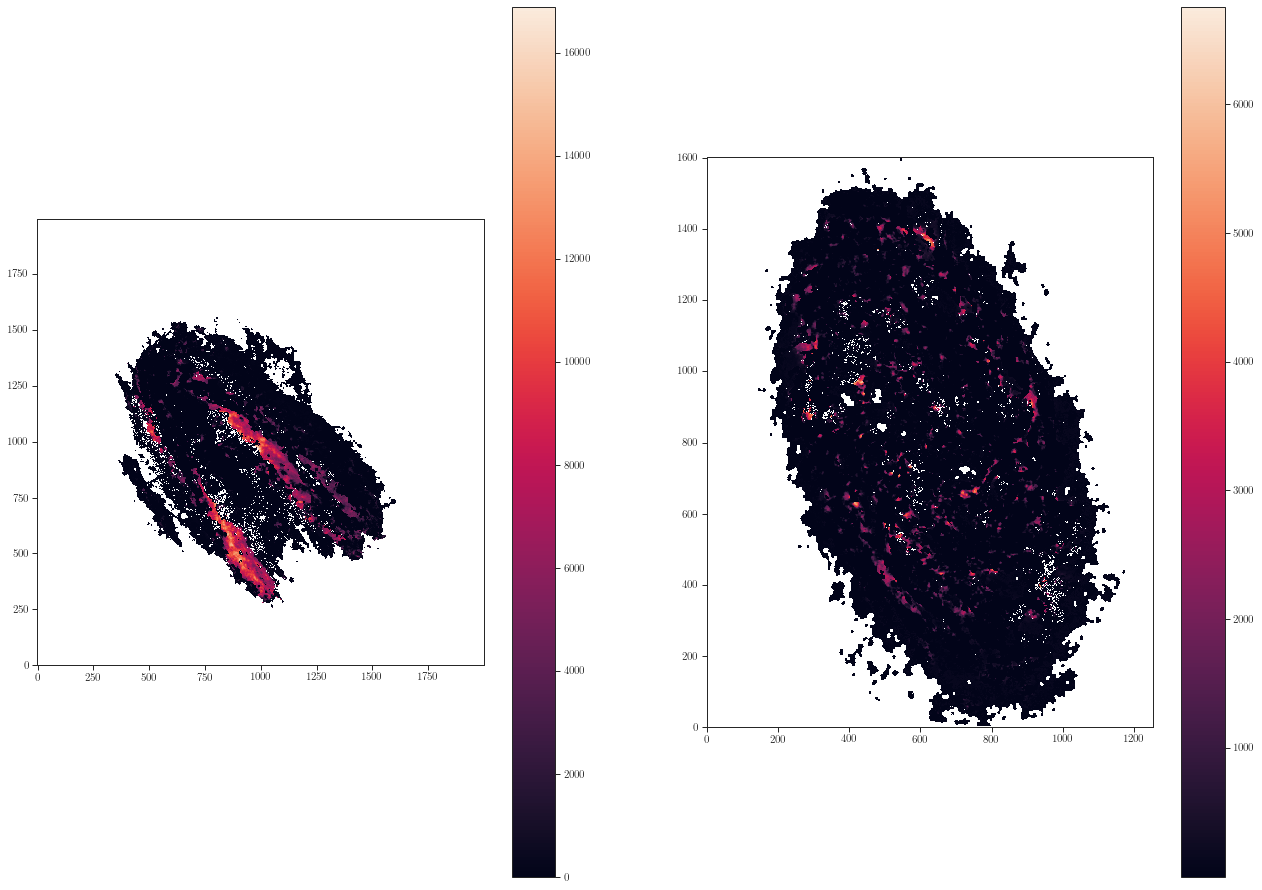

In [130]:
fig = plt.figure(figsize=(22, 16))


plt.subplot(121)
plt.imshow(m31_opcorr_mom0.value - m31_mom0.value, origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(m33_opcorr_mom0.value - m33_mom0.value, origin='lower')
plt.colorbar()


In [131]:
# Load in various dust maps. Dust column density from Utomo+19. Extinction map (M31) from Dalcanton+15

dust_path = Path("/home/ekoch/bigdata/ekoch/Utomo19_LGdust/")

dust_beam_m33 = Beam(41.0 * u.arcsec)

m33_dust_hdu = fits.open(dust_path / "M33" / "m33_dust.surface.density_FB.beta=1.8_gauss41.0_regrid_bksub.fits" )

m33_celest_hdr = WCS(m33_dust_hdu[0].header).celestial.to_header()
del m33_celest_hdr['MJD-OBS']

m33_dust_coldens = Projection.from_hdu(fits.PrimaryHDU(m33_dust_hdu[0].data[0], m33_celest_hdr))
m33_dust_coldens_err = Projection.from_hdu(fits.PrimaryHDU(m33_dust_hdu[0].data[2], m33_celest_hdr))

m33_dust_coldens = m33_dust_coldens.with_beam(dust_beam_m33)
m33_dust_coldens_err = m33_dust_coldens_err.with_beam(dust_beam_m33)

m33_dust_coldens_err = m33_dust_coldens_err[nd.find_objects(np.isfinite(m33_dust_coldens_err))[0]]
m33_dust_coldens = m33_dust_coldens[nd.find_objects(np.isfinite(m33_dust_coldens))[0]]

assert m33_dust_coldens.shape == m33_dust_coldens_err.shape

m31_dust_hdu = fits.open(dust_path / "M31" / "m31_dust.surface.density_FB.beta=1.8_gauss46.3_regrid_bksub.fits" )

m31_celest_hdr = WCS(m31_dust_hdu[0].header).celestial.to_header()
# del m31_celest_hdr['MJD-OBS']

dust_beam_m31 = Beam(46.3 * u.arcsec)

m31_dust_coldens = Projection.from_hdu(fits.PrimaryHDU(m31_dust_hdu[0].data[0], m31_celest_hdr))
m31_dust_coldens_err = Projection.from_hdu(fits.PrimaryHDU(m31_dust_hdu[0].data[2], m31_celest_hdr))

m31_dust_coldens = m31_dust_coldens.with_beam(dust_beam_m31)
m31_dust_coldens_err = m31_dust_coldens_err.with_beam(dust_beam_m31)

m31_dust_coldens_err = m31_dust_coldens_err[nd.find_objects(np.isfinite(m31_dust_coldens_err))[0]]
m31_dust_coldens = m31_dust_coldens[nd.find_objects(np.isfinite(m31_dust_coldens))[0]]

assert m31_dust_coldens.shape == m31_dust_coldens_err.shape

# M31 dust extinction

ext_path = Path("/home/ekoch/bigdata/ekoch/M31/PHAT/phat_dust_maps/")

m31_dust_ext = Projection.from_hdu(fits.open(ext_path / "phat_dalcanton.AV.fits"))
m31_dust_ext_err = Projection.from_hdu(fits.open(ext_path / "phat_dalcanton.AVerr.fits"))

# M31 CO

m31_co_mom0_hdu = fits.open(Path("/home/ekoch/bigdata/ekoch/M31/IRAM30m/") / "m31_iram_Kkms.fits")
m31_co_mom0 = Projection.from_hdu(m31_co_mom0_hdu)
m31_co_mom0._beam = Beam(23 * u.arcsec)

m31_co_mom0_smooth = m31_co_mom0.convolve_to(m31_dust_coldens.beam)
m31_co_mom0_rep = m31_co_mom0_smooth.reproject(m31_dust_coldens.header)

# M33 CO

# m33_co_mom0 = Projection.from_hdu(fits.open(Path("/home/ekoch/bigdata/ekoch/M33/co21/14B-088") / "m33.co21_iram.14B-088_HI.mom0.fits"))
m33_co_mom0 = Projection.from_hdu(fits.open(Path("/home/ekoch/bigdata/ekoch/M33/co21/14B-088") / "m33.co21_iram.14B-088_HI.mom0.fits"))
m33_co_mom0 = m33_co_mom0.to(u.K * u.km / u.s)

m33_co_mom0_smooth = m33_co_mom0.convolve_to(m33_dust_coldens.beam, nan_treatment='fill')
m33_co_mom0_rep = m33_co_mom0_smooth.reproject(m33_dust_coldens.header)


INFO:astropy:Auto-setting vmin to -1.090e+00
INFO:astropy:Auto-setting vmax to  6.288e+00


INFO: Auto-setting vmin to -1.090e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.288e+00 [aplpy.core]


INFO:astropy:Auto-setting vmin to -1.324e-01
INFO:astropy:Auto-setting vmax to  1.469e+00


INFO: Auto-setting vmin to -1.324e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.469e+00 [aplpy.core]


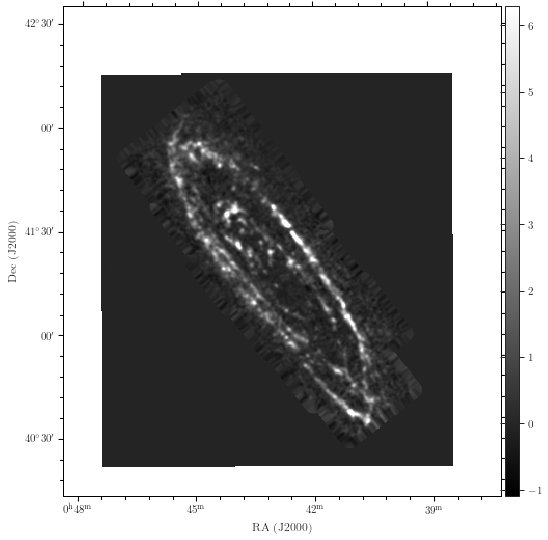

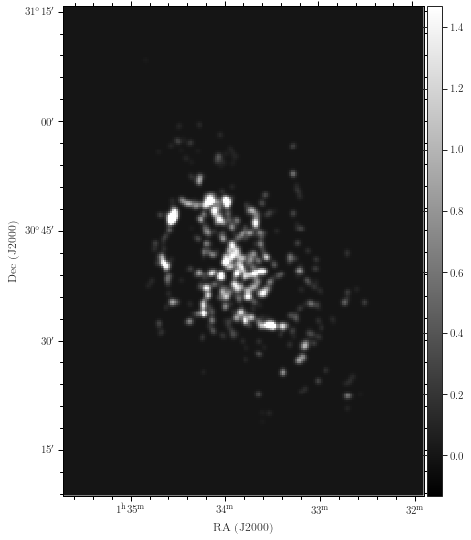

In [132]:
m31_co_mom0_rep.quicklook()
m33_co_mom0_rep.quicklook()

INFO:astropy:Auto-setting vmin to -2.036e-02
INFO:astropy:Auto-setting vmax to  2.321e-01


INFO: Auto-setting vmin to -2.036e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.321e-01 [aplpy.core]


INFO:astropy:Auto-setting vmin to -1.252e-02
INFO:astropy:Auto-setting vmax to  1.508e-01


INFO: Auto-setting vmin to -1.252e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.508e-01 [aplpy.core]


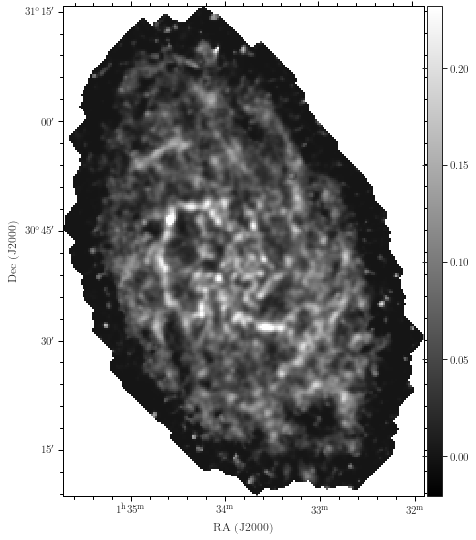

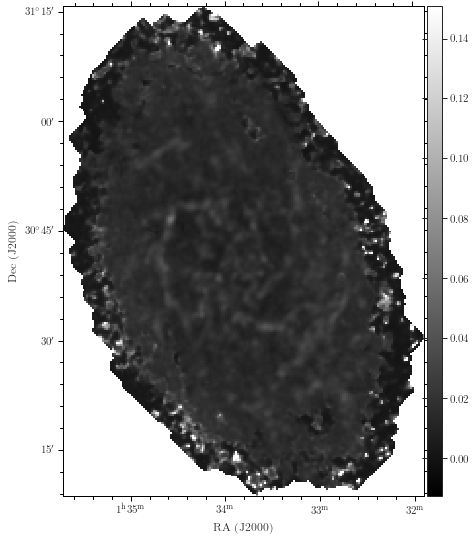

In [133]:
m33_dust_coldens.quicklook()
m33_dust_coldens_err.quicklook()

INFO:astropy:Auto-setting vmin to -6.332e-01
INFO:astropy:Auto-setting vmax to  8.235e+00


INFO: Auto-setting vmin to -6.332e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.235e+00 [aplpy.core]


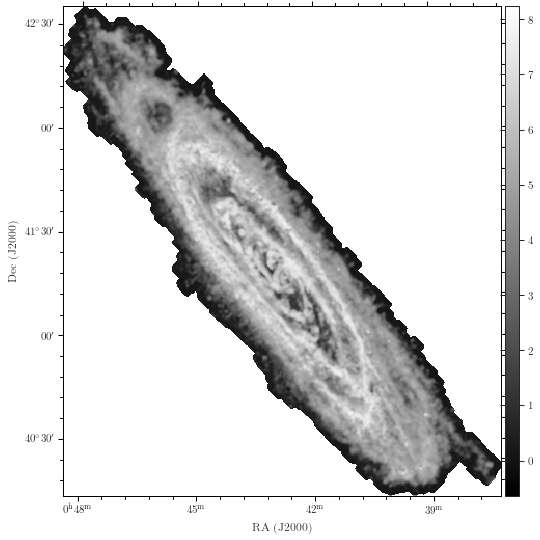

In [134]:
# m31_dust_coldens.quicklook()
# m31_dust_coldens_err.quicklook()

(m31_dust_coldens / m31_dust_coldens_err).quicklook()

Define dust masks to avoid noisy edges.

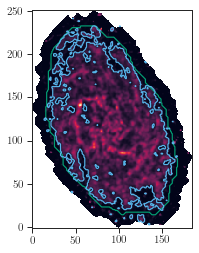

In [135]:
m33_coldens_mask = nd.binary_erosion(np.isfinite(m33_dust_coldens_err),
                                     structure=np.ones((3, 3)),
                                     iterations=10)

m33_coldens_sn_mask = (m33_dust_coldens / m33_dust_coldens_err).value > 2.

plt.imshow(m33_dust_coldens.value, origin='lower')
plt.contour(m33_coldens_mask, colors='g', levels=[0.5])
plt.contour(m33_coldens_sn_mask, colors='c', levels=[0.5])

m33_coldens_mask = np.logical_and(m33_coldens_mask, m33_coldens_sn_mask)

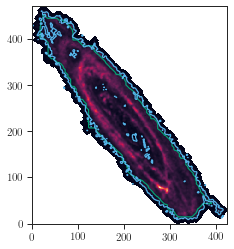

In [136]:
m31_coldens_mask = nd.binary_erosion(np.isfinite(m31_dust_coldens_err),
                                     structure=np.ones((3, 3)),
                                     iterations=11)

m31_coldens_sn_mask = (m31_dust_coldens / m31_dust_coldens_err).value > 2.

plt.imshow(m31_dust_coldens.value, origin='lower')
plt.contour(m31_coldens_mask, colors='g', levels=[0.5])
plt.contour(m31_coldens_sn_mask, colors='c', levels=[0.5])

m31_coldens_mask = np.logical_and(m31_coldens_mask, m31_coldens_sn_mask)

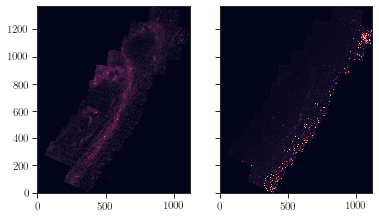

In [137]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[0].imshow(m31_dust_ext.value, origin='lower')
axs[1].imshow(m31_dust_ext_err.value, origin='lower')

Make CO masks for later plots that will exclude H2 regions.

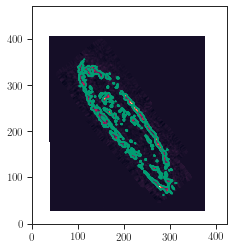

In [138]:
# intint_min = 2.5 / (4.8 * np.cos(77 * u.deg)).value
intint_min = 1.5 / (4.8 * np.cos(77 * u.deg)).value

m31_co_mask = m31_co_mom0_rep.value > intint_min

plt.imshow(m31_co_mom0_rep.value, origin='lower')
plt.contour(m31_co_mask, colors='g')

0.3911887984312439


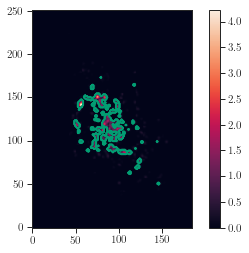

In [139]:
# intint_min_co21 = 2.5 / ((4.8 / 0.7) * np.cos(56 * u.deg)).value
intint_min_co21 = 1.5 / ((4.8 / 0.7) * np.cos(56 * u.deg)).value

print(intint_min_co21)

m33_co_mask = m33_co_mom0_rep.value > intint_min_co21

plt.imshow(m33_co_mom0_rep.value, origin='lower')
plt.colorbar()
plt.contour(m33_co_mask, colors='g')

In [140]:
# Get pixscale in deg for the extinction maps.

from astropy.wcs.utils import proj_plane_pixel_scales
pixscale_ext = proj_plane_pixel_scales(m31_dust_ext.wcs)[0] * u.deg

print(pixscale_ext.to(u.arcsec))

3.299674264881984 arcsec


1.0
0.9999999999999998


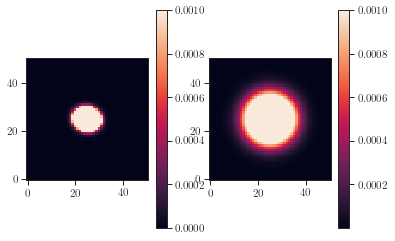

In [141]:
# Define the extinction beam and transformations to a 2D Gaussian

import photutils

from astropy.modeling.models import Box2D

m31_ext_beam = Box2D(1, x_0=25, y_0=25)

ys, xs = np.mgrid[0:51, 0:51]

m31_ext_kernel = m31_ext_beam(ys, xs)
print(m31_ext_kernel.sum())


# HI beam

m31_hi_beam = m31_mom0.beam

m31_hi_kernel = m31_hi_beam.as_kernel(pixscale=pixscale_ext, x_size=51, y_size=51)
print(m31_hi_kernel.array.sum())

# window = photutils.TopHatWindow(0.35)
m31_hi_ext_match_kernel = photutils.create_matching_kernel(m31_ext_kernel, m31_hi_kernel,
                                                           window=None)
plt.subplot(121)
plt.imshow(m31_hi_ext_match_kernel, vmax=0.001)
plt.colorbar()

# Looks good. Now for the dust.

m31_dust_beam = m31_dust_coldens.beam

m31_dust_kernel = m31_dust_beam.as_kernel(pixscale=pixscale_ext, x_size=51, y_size=51)

m31_dust_ext_match_kernel = photutils.create_matching_kernel(m31_ext_kernel, m31_dust_kernel,
                                                             window=None)

plt.subplot(122)
plt.imshow(m31_dust_ext_match_kernel, vmax=0.001)
plt.colorbar()



In [142]:
# Try reprojecting the M31 data to match the dust emission col. density:
# Convolve to the HI and dust beams.

from astropy.convolution import convolve_fft

m31_ext_hi_data = convolve_fft(m31_dust_ext.value, m31_hi_ext_match_kernel)

m31_ext_dust_data = convolve_fft(m31_dust_ext.value, m31_dust_ext_match_kernel)

m31_ext_matchhi = Projection.from_hdu(fits.PrimaryHDU(m31_ext_hi_data, m31_dust_ext.header))
m31_ext_matchdust = Projection.from_hdu(fits.PrimaryHDU(m31_ext_dust_data, m31_dust_ext.header))

m31_ext_matchhi_rep = m31_ext_matchhi.reproject(m31_mom0.header)
m31_ext_matchdust_rep = m31_ext_matchdust.reproject(m31_dust_coldens.header)


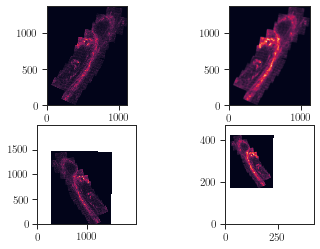

In [143]:

plt.subplot(221)
plt.imshow(m31_ext_hi_data, origin='lower')
plt.subplot(222)
plt.imshow(m31_ext_dust_data, origin='lower')

plt.subplot(223)
plt.imshow(m31_ext_matchhi_rep.value, origin='lower')
plt.subplot(224)
plt.imshow(m31_ext_matchdust_rep.value, origin='lower')


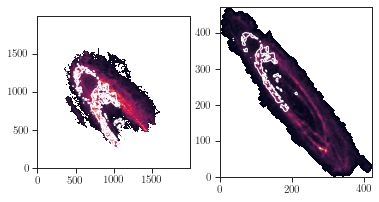

In [144]:
plt.subplot(121)
plt.imshow(m31_mom0.value, origin='lower')
plt.contour(m31_ext_matchhi_rep.value, levels=[1.0, 2.0], colors='w')

plt.subplot(122)
plt.imshow(m31_dust_coldens.value, origin='lower')
plt.contour(m31_ext_matchdust_rep.value, levels=[1.0, 2.0], colors='w')


In [145]:
# Also smooth and reproject the HI maps to match the dust emission

m31_opcorr_mom0_smooth = m31_opcorr_mom0.convolve_to(m31_dust_coldens.beam)
m31_mom0_smooth = m31_mom0.convolve_to(m31_dust_coldens.beam)

m31_opcorr_mom0_matchdust = m31_opcorr_mom0_smooth.reproject(m31_dust_coldens.header)
m31_mom0_matchdust = m31_mom0_smooth.reproject(m31_dust_coldens.header)

m33_opcorr_mom0_smooth = m33_opcorr_mom0.convolve_to(m33_dust_coldens.beam)
m33_mom0_smooth = m33_mom0.convolve_to(m33_dust_coldens.beam)

m33_opcorr_mom0_matchdust = m33_opcorr_mom0_smooth.reproject(m33_dust_coldens.header)
m33_mom0_matchdust = m33_mom0_smooth.reproject(m33_dust_coldens.header)



We should be ready for some plots now!

* M31 and M33 dust vs. HI surface density
  * all points (to check)
  * CO masked (for paper)
  * Show dust-to-gas ratios needed to account for "opcorr" values
* M31 extinction vs HI integrated intensity
  * CO masked (for paper)



Comparisons with matching the extinction map.

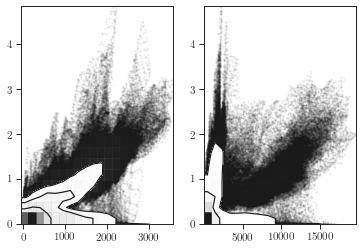

In [146]:
hi_ext_mask = np.logical_and(np.isfinite(m31_mom0), np.isfinite(m31_ext_matchhi_rep))
hi_ext_mask_opcorr = np.logical_and(np.isfinite(m31_opcorr_mom0), np.isfinite(m31_ext_matchhi_rep))

fig, axs = plt.subplots(1, 2)

# plt.scatter(m31_mom0[hi_ext_mask], m31_ext_matchhi_rep[hi_ext_mask])
hist2d(m31_mom0.value[hi_ext_mask], m31_ext_matchhi_rep.value[hi_ext_mask], ax=axs[0])
hist2d(m31_opcorr_mom0.value[hi_ext_mask_opcorr], m31_ext_matchhi_rep.value[hi_ext_mask_opcorr], ax=axs[1])

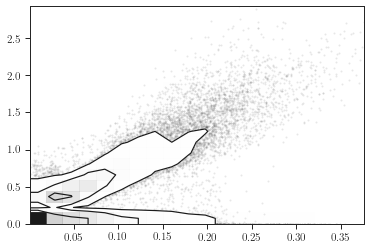

In [147]:
dust_ext_mask = np.logical_and(np.isfinite(m31_dust_coldens), np.isfinite(m31_ext_matchdust_rep))

# plt.scatter(m31_mom0[hi_ext_mask], m31_ext_matchhi_rep[hi_ext_mask])
hist2d(m31_dust_coldens.value[dust_ext_mask], m31_ext_matchdust_rep.value[dust_ext_mask])


Comparisons of HI and dust emission at matched resolution.

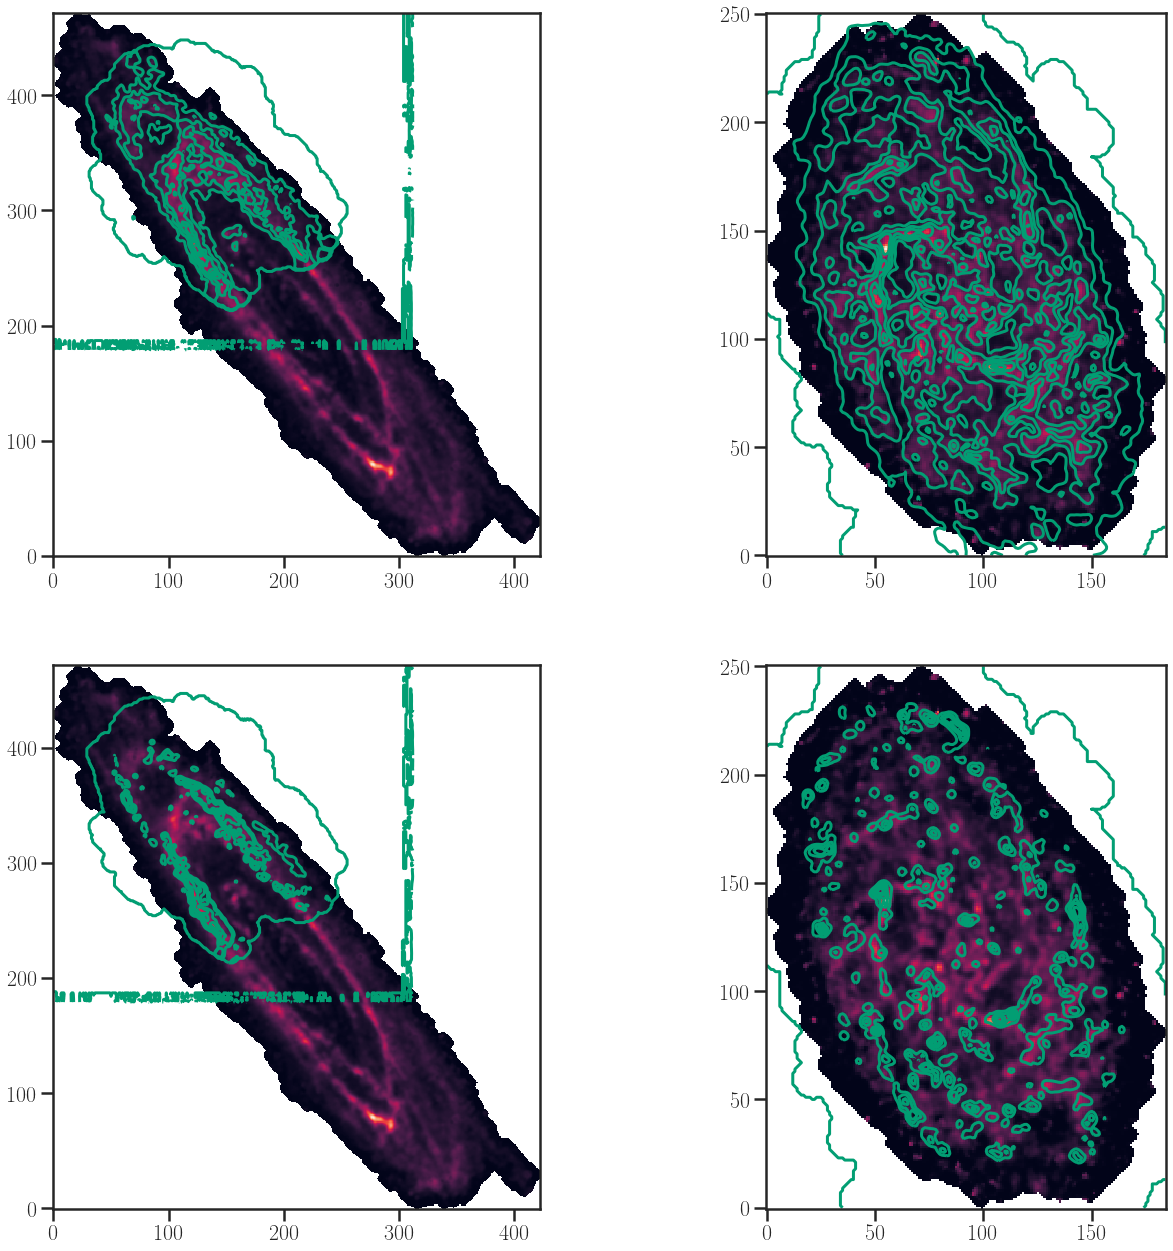

In [148]:
default_figure()

fig = plt.figure(figsize=(22, 22))

plt.subplot(221)
plt.imshow(m31_dust_coldens.value, origin='lower')
plt.contour(m31_mom0_matchdust.value, colors='g', levels=5)

plt.subplot(222)
plt.imshow(m33_dust_coldens.value, origin='lower')
plt.contour(m33_mom0_matchdust.value, colors='g', levels=5)

plt.subplot(223)
plt.imshow(m31_dust_coldens.value, origin='lower')
plt.contour(m31_opcorr_mom0_matchdust.value, colors='g', levels=5)

plt.subplot(224)
plt.imshow(m33_dust_coldens.value, origin='lower')
plt.contour(m33_opcorr_mom0_matchdust.value, colors='g', levels=5)

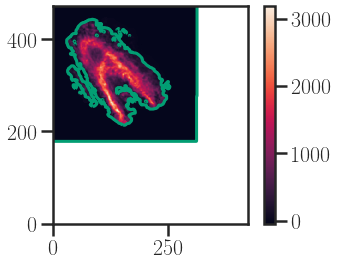

In [149]:
# plt.imshow(m31_dust_coldens.value, origin='lower')
plt.imshow(m31_mom0_matchdust.value, origin='lower')
plt.colorbar()
plt.contour(np.isfinite(m31_mom0_matchdust.value), colors='g', levels=[0.5])
plt.contour(m31_mom0_matchdust.value > 100, colors='g', levels=[0.5])

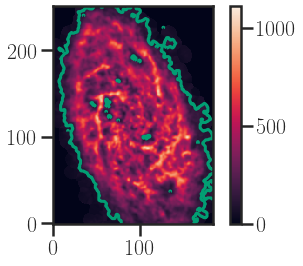

In [150]:
# plt.imshow(m31_dust_coldens.value, origin='lower')
plt.imshow(m33_mom0_matchdust.value, origin='lower')
plt.colorbar()
plt.contour(np.isfinite(m33_mom0_matchdust.value), colors='g', levels=[0.5])
plt.contour(m33_mom0_matchdust.value > 100, colors='g', levels=[0.5])

In [151]:
# Options for hist2d set in one place

data_kwargs = {'alpha': 0.3}

0.08462082040709752
(18170,)
(18055,)


Text(0.5, 1.0, 'With inferred opacity correction')

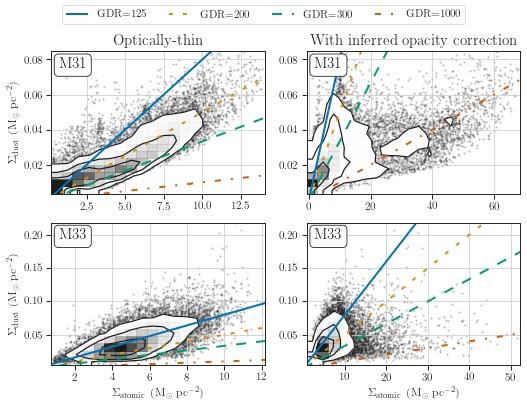

In [152]:

twocolumn_figure()

hi_coldens_factor = 0.0196

m31_inc_corr = np.cos(77 * u.deg).value
m33_inc_corr = np.cos(56 * u.deg).value

# m31_hi_dust_mask = np.logical_and(np.isfinite(m31_mom0_matchdust), m31_coldens_mask)
m31_hi_dust_mask = np.logical_and(m31_mom0_matchdust.value > 50, m31_coldens_mask)

m33_hi_dust_mask = np.logical_and(m33_mom0_matchdust.value > 50, m33_coldens_mask)

# hi_ext_mask_opcorr = np.logical_and(np.isfinite(m31_opcorr_mom0), np.isfinite(m31_ext_matchhi_rep))

fig, axs = plt.subplots(2, 2)

print(np.nanmax(m31_dust_coldens.value[m31_hi_dust_mask] * m31_inc_corr))

hist2d(hi_coldens_factor * m33_mom0_matchdust.value[m33_hi_dust_mask] * m33_inc_corr,
       m33_dust_coldens.value[m33_hi_dust_mask] * m33_inc_corr, ax=axs[1, 0], data_kwargs=data_kwargs)
hist2d(hi_coldens_factor * m33_opcorr_mom0_matchdust.value[m33_hi_dust_mask] * m33_inc_corr,
       m33_dust_coldens.value[m33_hi_dust_mask] * m33_inc_corr, ax=axs[1, 1], data_kwargs=data_kwargs)

hist2d(hi_coldens_factor * m31_mom0_matchdust.value[m31_hi_dust_mask] * m31_inc_corr,
       m31_dust_coldens.value[m31_hi_dust_mask] * m31_inc_corr, ax=axs[0, 0], data_kwargs=data_kwargs)
hist2d(hi_coldens_factor * m31_opcorr_mom0_matchdust.value[m31_hi_dust_mask] * m31_inc_corr,
       m31_dust_coldens.value[m31_hi_dust_mask] * m31_inc_corr, ax=axs[0, 1],
       bins=[20, 20], data_kwargs=data_kwargs)

print(m31_mom0_matchdust.value[m31_hi_dust_mask].shape)
print(m33_mom0_matchdust.value[m33_hi_dust_mask].shape)

bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp, yp = 0.1, 0.95

axs[0, 0].text(xp, yp, "M31", # \nOptically-thin",
               transform=axs[0, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='top',
               bbox=bbox_props, fontsize=15)
axs[0, 1].text(xp, yp, "M31", # \nInferred opaque correction",
               transform=axs[0, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='top',
               bbox=bbox_props, fontsize=15)

axs[1, 0].text(xp, yp, "M33", # \nOptically-thin",
               transform=axs[1, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='top',
               bbox=bbox_props, fontsize=15)
axs[1, 1].text(xp, yp, "M33", # \nInferred opaque correction",
               transform=axs[1, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='top',
               bbox=bbox_props, fontsize=15)

[ax.grid(True) for ax in axs.ravel()]

xlims = np.array([[60, 320], [25, 90]])
gdrs = [125, 200, 300, 1000]

lstyles = [linestyles['solid'],
           linestyles['dotted'],
           linestyles['dashed'],
           linestyles['dashdotted'],
           linestyles['densely dashed']]

for i, (ax, xl) in enumerate(zip(axs.ravel(), xlims.ravel())):
    for gdr, lstyle in zip(gdrs, lstyles):
        im = ax.plot([0, xl], np.array([0, xl]) / gdr, label=f"GDR={gdr}",
                     linestyle=lstyle, linewidth=2)

# axs[0].plot([0, 65], np.array([0, 65]) / 100, 'g--', label='GDR=100')
# axs[0].plot([0, 65], np.array([0, 65]) / 200, 'b:', label='GDR=200')
# axs[0].plot([0, 65], np.array([0, 65]) / 300, 'r-.', label='GDR=300')
# axs[0].plot([0, 65], np.array([0, 65]) / 500, 'r-.', label='GDR=500')
# axs[0].plot([0, 65], np.array([0, 65]) / 1000, 'r-.', label='GDR=1000')

handles, labels = axs[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=5, loc='upper center')
# axs[0].legend(frameon=True, ncol=2)

axs[1, 0].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")
axs[1, 1].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")

axs[1, 0].set_ylabel(r"$\Sigma_{\rm dust}$ (M$_\odot$ pc$^{-2}$)")
axs[0, 0].set_ylabel(r"$\Sigma_{\rm dust}$ (M$_\odot$ pc$^{-2}$)")

axs[0, 0].set_title("Optically-thin", fontsize=15)
axs[0, 1].set_title("With inferred opacity correction", fontsize=15)

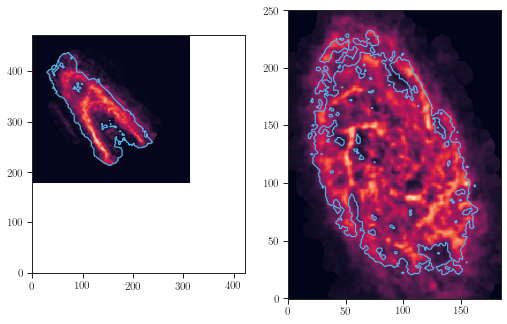

In [153]:
# Check the masks we're using:

plt.subplot(121)
plt.imshow(m31_mom0_matchdust.value, origin='lower')
plt.contour(m31_hi_dust_mask, colors='c', levels=[0.5])

plt.subplot(122)
plt.imshow(m33_mom0_matchdust.value, origin='lower')
plt.contour(m33_hi_dust_mask, colors='c', levels=[0.5])


In [160]:
m31_dust_coldens.beam
# m31_mom0_matchdust.beam
m33_dust_coldens.beam

Beam: BMAJ=41.0 arcsec BMIN=41.0 arcsec BPA=0.0 deg

Add in CO mask

(15426,)
(16867,)


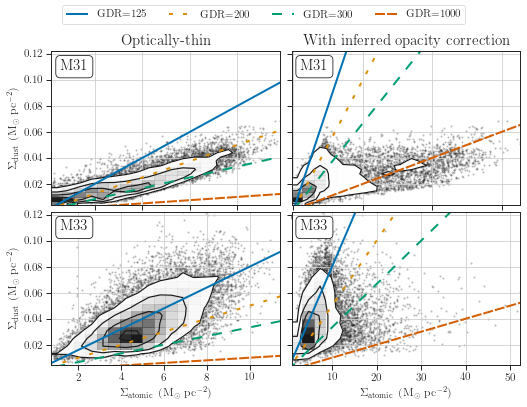

In [155]:

twocolumn_figure()

hi_coldens_factor = 0.0196

m31_inc_corr = np.cos(77 * u.deg).value
m33_inc_corr = np.cos(56 * u.deg).value

# m31_hi_dust_mask = np.logical_and(np.isfinite(m31_mom0_matchdust), m31_coldens_mask)
m31_hi_dust_mask = np.logical_and(m31_mom0_matchdust.value > 50, m31_coldens_mask)
m31_hi_dust_mask = np.logical_and(m31_hi_dust_mask, ~m31_co_mask)

m33_hi_dust_mask = np.logical_and(m33_mom0_matchdust.value > 50, m33_coldens_mask)
m33_hi_dust_mask = np.logical_and(m33_hi_dust_mask, ~m33_co_mask)

# hi_ext_mask_opcorr = np.logical_and(np.isfinite(m31_opcorr_mom0), np.isfinite(m31_ext_matchhi_rep))

fig, axs = plt.subplots(2, 2, sharey=True)

hist2d(hi_coldens_factor * m31_mom0_matchdust.value[m31_hi_dust_mask] * m31_inc_corr,
       m31_dust_coldens.value[m31_hi_dust_mask] * m31_inc_corr,
       ax=axs[0, 0], data_kwargs=data_kwargs)
hist2d(hi_coldens_factor * m31_opcorr_mom0_matchdust.value[m31_hi_dust_mask] * m31_inc_corr,
       m31_dust_coldens.value[m31_hi_dust_mask] * m31_inc_corr,
       ax=axs[0, 1],
       bins=[20, 20], data_kwargs=data_kwargs)

hist2d(hi_coldens_factor * m33_mom0_matchdust.value[m33_hi_dust_mask] * m33_inc_corr,
       m33_dust_coldens.value[m33_hi_dust_mask] * m33_inc_corr,
       ax=axs[1, 0], data_kwargs=data_kwargs)
hist2d(hi_coldens_factor * m33_opcorr_mom0_matchdust.value[m33_hi_dust_mask] * m33_inc_corr,
       m33_dust_coldens.value[m33_hi_dust_mask] * m33_inc_corr,
       ax=axs[1, 1], data_kwargs=data_kwargs)

print(m31_mom0_matchdust.value[m31_hi_dust_mask].shape)
print(m33_mom0_matchdust.value[m33_hi_dust_mask].shape)

bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp, yp = 0.1, 0.9

axs[0, 0].text(xp, yp, "M31", # \nOptically-thin",
               transform=axs[0, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)
axs[0, 1].text(xp, yp, "M31", # \nInferred opaque correction",
               transform=axs[0, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)

axs[1, 0].text(xp, yp, "M33", # \nOptically-thin",
               transform=axs[1, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)
axs[1, 1].text(xp, yp, "M33", # \nInferred opaque correction",
               transform=axs[1, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)

[ax.grid(True) for ax in axs.ravel()]

# xlims = np.array([[60, 320], [25, 90]])
xlims = np.array([[60, 320], [60, 320]])
gdrs = [125, 200, 300, 1000]

lstyles = [linestyles['solid'],
           linestyles['dotted'],
           linestyles['dashed'],
#            linestyles['dashdotted'],
           linestyles['densely dashed']]

for i, (ax, xl) in enumerate(zip(axs.ravel(), xlims.ravel())):
    for gdr, lstyle in zip(gdrs, lstyles):
        im = ax.plot([0, xl], np.array([0, xl]) / gdr, label=f"GDR={gdr}",
                     linestyle=lstyle, linewidth=2)

# axs[0].plot([0, 65], np.array([0, 65]) / 100, 'g--', label='GDR=100')
# axs[0].plot([0, 65], np.array([0, 65]) / 200, 'b:', label='GDR=200')
# axs[0].plot([0, 65], np.array([0, 65]) / 300, 'r-.', label='GDR=300')
# axs[0].plot([0, 65], np.array([0, 65]) / 500, 'r-.', label='GDR=500')
# axs[0].plot([0, 65], np.array([0, 65]) / 1000, 'r-.', label='GDR=1000')

handles, labels = axs[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=5, loc='upper center')
# axs[0].legend(frameon=True, ncol=2)

axs[1, 0].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")
axs[1, 1].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")

axs[1, 0].set_ylabel(r"$\Sigma_{\rm dust}$ (M$_\odot$ pc$^{-2}$)")
axs[0, 0].set_ylabel(r"$\Sigma_{\rm dust}$ (M$_\odot$ pc$^{-2}$)")

axs[0, 0].set_title("Optically-thin", fontsize=15)
axs[0, 1].set_title("With inferred opacity correction", fontsize=15)

plt.subplots_adjust(hspace=0.05, wspace=0.05)

if save_figures:
    save_figure(fig, "m31_m33_hi_dust_wGDR_COmasked", bbox_inches='tight', dpi=300)

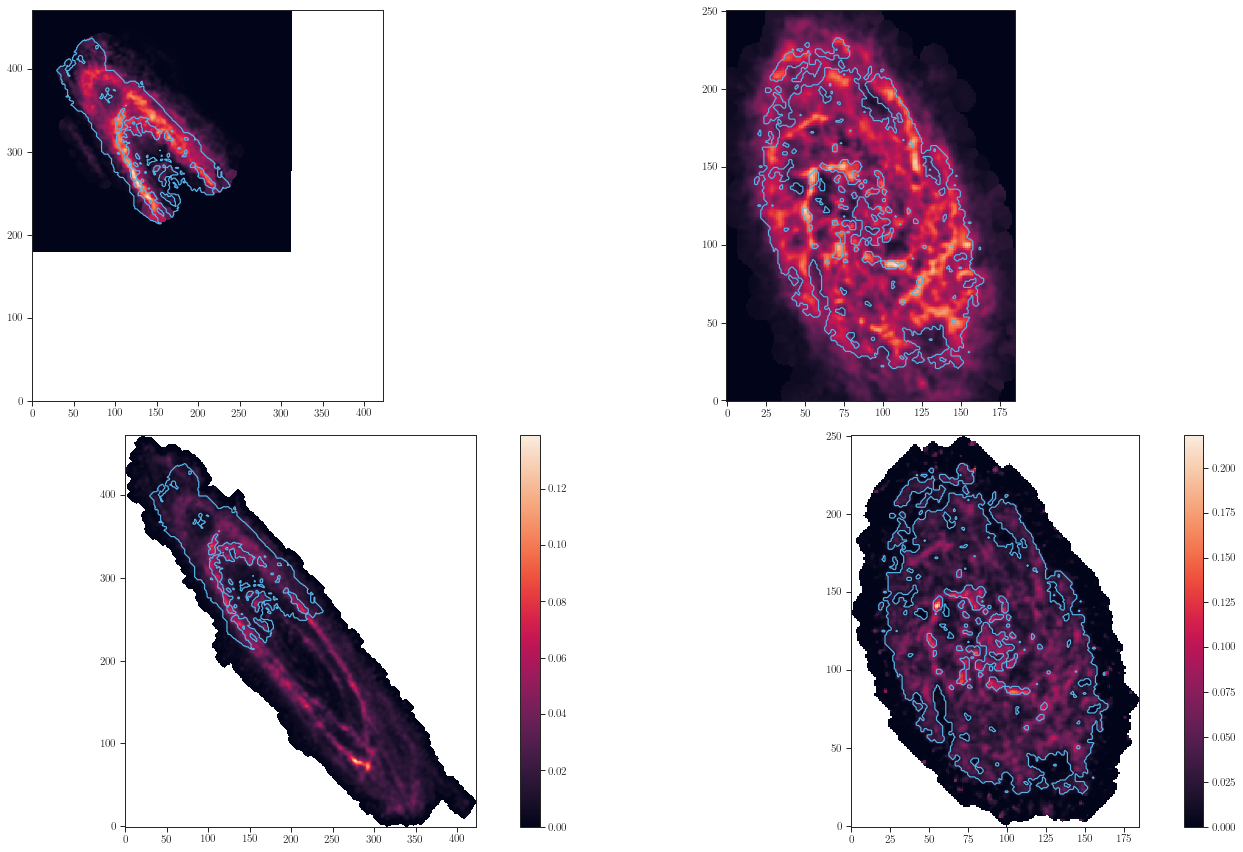

In [156]:
# Check the masks we're using:

plt.figure(figsize=(22, 12))

plt.subplot(221)
plt.imshow(m31_mom0_matchdust.value, origin='lower', vmin=0.)
plt.contour(m31_hi_dust_mask, colors='c', levels=[0.5])

plt.subplot(222)
plt.imshow(m33_mom0_matchdust.value, origin='lower', vmin=0.)
plt.contour(m33_hi_dust_mask, colors='c', levels=[0.5])

plt.subplot(223)
plt.imshow(m31_dust_coldens.value * m31_inc_corr, origin='lower', vmin=0.)
plt.colorbar()
plt.contour(m31_hi_dust_mask, colors='c', levels=[0.5])

plt.subplot(224)
plt.imshow(m33_dust_coldens.value * m33_inc_corr, origin='lower', vmin=0.)
plt.colorbar()
plt.contour(m33_hi_dust_mask, colors='c', levels=[0.5])

plt.tight_layout()

(15426,)
(16867,)


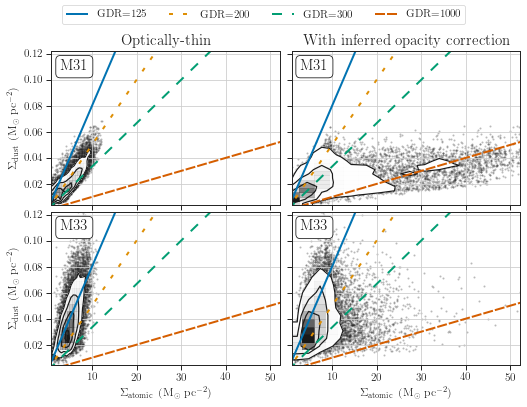

In [157]:

twocolumn_figure()

hi_coldens_factor = 0.0196

m31_inc_corr = np.cos(77 * u.deg).value
m33_inc_corr = np.cos(56 * u.deg).value

# m31_hi_dust_mask = np.logical_and(np.isfinite(m31_mom0_matchdust), m31_coldens_mask)
m31_hi_dust_mask = np.logical_and(m31_mom0_matchdust.value > 50, m31_coldens_mask)
m31_hi_dust_mask = np.logical_and(m31_hi_dust_mask, ~m31_co_mask)

m33_hi_dust_mask = np.logical_and(m33_mom0_matchdust.value > 50, m33_coldens_mask)
m33_hi_dust_mask = np.logical_and(m33_hi_dust_mask, ~m33_co_mask)

# hi_ext_mask_opcorr = np.logical_and(np.isfinite(m31_opcorr_mom0), np.isfinite(m31_ext_matchhi_rep))

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

hist2d(hi_coldens_factor * m31_mom0_matchdust.value[m31_hi_dust_mask] * m31_inc_corr,
       m31_dust_coldens.value[m31_hi_dust_mask] * m31_inc_corr,
       ax=axs[0, 0], data_kwargs=data_kwargs)
hist2d(hi_coldens_factor * m31_opcorr_mom0_matchdust.value[m31_hi_dust_mask] * m31_inc_corr,
       m31_dust_coldens.value[m31_hi_dust_mask] * m31_inc_corr,
       ax=axs[0, 1],
       bins=[20, 20], data_kwargs=data_kwargs)

hist2d(hi_coldens_factor * m33_mom0_matchdust.value[m33_hi_dust_mask] * m33_inc_corr,
       m33_dust_coldens.value[m33_hi_dust_mask] * m33_inc_corr,
       ax=axs[1, 0], data_kwargs=data_kwargs)
hist2d(hi_coldens_factor * m33_opcorr_mom0_matchdust.value[m33_hi_dust_mask] * m33_inc_corr,
       m33_dust_coldens.value[m33_hi_dust_mask] * m33_inc_corr,
       ax=axs[1, 1], data_kwargs=data_kwargs)

print(m31_mom0_matchdust.value[m31_hi_dust_mask].shape)
print(m33_mom0_matchdust.value[m33_hi_dust_mask].shape)

bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp, yp = 0.1, 0.9

axs[0, 0].text(xp, yp, "M31", # \nOptically-thin",
               transform=axs[0, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)
axs[0, 1].text(xp, yp, "M31", # \nInferred opaque correction",
               transform=axs[0, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)

axs[1, 0].text(xp, yp, "M33", # \nOptically-thin",
               transform=axs[1, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)
axs[1, 1].text(xp, yp, "M33", # \nInferred opaque correction",
               transform=axs[1, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)

[ax.grid(True) for ax in axs.ravel()]

# xlims = np.array([[60, 320], [25, 90]])
xlims = np.array([[60, 320], [60, 320]])
gdrs = [125, 200, 300, 1000]

lstyles = [linestyles['solid'],
           linestyles['dotted'],
           linestyles['dashed'],
#            linestyles['dashdotted'],
           linestyles['densely dashed']]

for i, (ax, xl) in enumerate(zip(axs.ravel(), xlims.ravel())):
    for gdr, lstyle in zip(gdrs, lstyles):
        im = ax.plot([0, xl], np.array([0, xl]) / gdr, label=f"GDR={gdr}",
                     linestyle=lstyle, linewidth=2)

# axs[0].plot([0, 65], np.array([0, 65]) / 100, 'g--', label='GDR=100')
# axs[0].plot([0, 65], np.array([0, 65]) / 200, 'b:', label='GDR=200')
# axs[0].plot([0, 65], np.array([0, 65]) / 300, 'r-.', label='GDR=300')
# axs[0].plot([0, 65], np.array([0, 65]) / 500, 'r-.', label='GDR=500')
# axs[0].plot([0, 65], np.array([0, 65]) / 1000, 'r-.', label='GDR=1000')

handles, labels = axs[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=5, loc='upper center')
# axs[0].legend(frameon=True, ncol=2)

axs[1, 0].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")
axs[1, 1].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")

axs[1, 0].set_ylabel(r"$\Sigma_{\rm dust}$ (M$_\odot$ pc$^{-2}$)")
axs[0, 0].set_ylabel(r"$\Sigma_{\rm dust}$ (M$_\odot$ pc$^{-2}$)")

axs[0, 0].set_title("Optically-thin", fontsize=15)
axs[0, 1].set_title("With inferred opacity correction", fontsize=15)

plt.subplots_adjust(hspace=0.05, wspace=0.05)

if save_figures:
    save_figure(fig, "m31_m33_hi_dust_wGDR_COmasked_matchxrange", bbox_inches='tight', dpi=300)

Next plot: M31 HI vs. extinction.

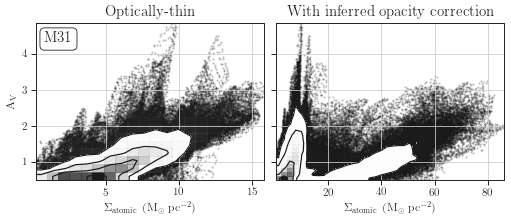

In [158]:
# onecolumn_figure()
twocolumn_twopanel_figure()

fig, axs = plt.subplots(1, 2, sharey=True)

m31_av_mask = m31_ext_matchhi_rep.value > 0.5

m31_hi_av_mask = np.logical_and(m31_mom0.value > 50, m31_av_mask)
m31_hi_av_mask = np.logical_and(m31_hi_av_mask, np.isfinite(m31_opcorr_mom0))

hist2d(hi_coldens_factor * m31_mom0.value[m31_hi_av_mask] * m31_inc_corr,
       m31_ext_matchhi_rep.value[m31_hi_av_mask], # * m31_inc_corr,
       ax=axs[0], data_kwargs=data_kwargs)
hist2d(hi_coldens_factor * m31_opcorr_mom0.value[m31_hi_av_mask] * m31_inc_corr,
       m31_ext_matchhi_rep.value[m31_hi_av_mask], # * m31_inc_corr,
       ax=axs[1],
       bins=[40, 40], data_kwargs=data_kwargs)

[ax.grid(True) for ax in axs.ravel()]

axs[0].set_ylabel(r"A$_{\rm V}$")
axs[0].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")
axs[1].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")

axs[0].set_title("Optically-thin", fontsize=15)
axs[1].set_title("With inferred opacity correction", fontsize=15)

bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp, yp = 0.1, 0.9

axs[0].text(xp, yp, "M31", # \nOptically-thin",
            transform=axs[0].transAxes,
            horizontalalignment='center',
            verticalalignment='center',
            bbox=bbox_props, fontsize=15)


plt.subplots_adjust(hspace=0.05, wspace=0.05)

if save_figures:
    save_figure(fig, "m31_hi_Av", bbox_inches='tight', dpi=300)

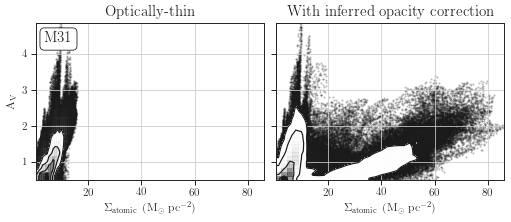

In [159]:
# onecolumn_figure()
twocolumn_twopanel_figure()

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

m31_av_mask = m31_ext_matchhi_rep.value > 0.5

m31_hi_av_mask = np.logical_and(m31_mom0.value > 50, m31_av_mask)
m31_hi_av_mask = np.logical_and(m31_hi_av_mask, np.isfinite(m31_opcorr_mom0))

hist2d(hi_coldens_factor * m31_mom0.value[m31_hi_av_mask] * m31_inc_corr,
       m31_ext_matchhi_rep.value[m31_hi_av_mask], # * m31_inc_corr,
       ax=axs[0], data_kwargs=data_kwargs)
hist2d(hi_coldens_factor * m31_opcorr_mom0.value[m31_hi_av_mask] * m31_inc_corr,
       m31_ext_matchhi_rep.value[m31_hi_av_mask], # * m31_inc_corr,
       ax=axs[1],
       bins=[40, 40], data_kwargs=data_kwargs)

[ax.grid(True) for ax in axs.ravel()]

axs[0].set_ylabel(r"A$_{\rm V}$")
axs[0].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")
axs[1].set_xlabel(r"$\Sigma_{\rm atomic}$ (M$_\odot$ pc$^{-2}$)")

axs[0].set_title("Optically-thin", fontsize=15)
axs[1].set_title("With inferred opacity correction", fontsize=15)

bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp, yp = 0.1, 0.9

axs[0].text(xp, yp, "M31", # \nOptically-thin",
            transform=axs[0].transAxes,
            horizontalalignment='center',
            verticalalignment='center',
            bbox=bbox_props, fontsize=15)

plt.subplots_adjust(hspace=0.05, wspace=0.05)

if save_figures:
    save_figure(fig, "m31_hi_Av_matchxrange", bbox_inches='tight', dpi=300)